In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [7]:
#vgg16を使う
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import torch

from misc_functions import get_example_params, convert_to_grayscale, save_gradient_images

In [8]:
vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)

In [9]:
parm={}
for name,parameters in vgg16.named_parameters():
    print(name,':',parameters.size())
    parm[name]=parameters.detach().numpy()

features.0.weight : torch.Size([64, 3, 3, 3])
features.0.bias : torch.Size([64])
features.2.weight : torch.Size([64, 64, 3, 3])
features.2.bias : torch.Size([64])
features.5.weight : torch.Size([128, 64, 3, 3])
features.5.bias : torch.Size([128])
features.7.weight : torch.Size([128, 128, 3, 3])
features.7.bias : torch.Size([128])
features.10.weight : torch.Size([256, 128, 3, 3])
features.10.bias : torch.Size([256])
features.12.weight : torch.Size([256, 256, 3, 3])
features.12.bias : torch.Size([256])
features.14.weight : torch.Size([256, 256, 3, 3])
features.14.bias : torch.Size([256])
features.17.weight : torch.Size([512, 256, 3, 3])
features.17.bias : torch.Size([512])
features.19.weight : torch.Size([512, 512, 3, 3])
features.19.bias : torch.Size([512])
features.21.weight : torch.Size([512, 512, 3, 3])
features.21.bias : torch.Size([512])
features.24.weight : torch.Size([512, 512, 3, 3])
features.24.bias : torch.Size([512])
features.26.weight : torch.Size([512, 512, 3, 3])
features.

In [10]:
np.mean(parm["features.28.weight"], axis = (1,2,3)).shape
#parm["features.28.weight"].shape

(512,)

In [11]:
from PIL import Image
import numpy as np
import torch

from misc_functions import get_example_params, save_class_activation_images


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


In [14]:
class OriginalCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_originalcam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients CAM:use the weight of net
        weights = np.mean(parm["features.28.weight"], axis = (1,2,3))
        # Create empty numpy array for cam
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam -= w * target[i,:,:] 
        cam /= np.max(cam)
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
       
        return cam

In [15]:
# Get params
target_example = 4
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
# cam
cam = OriginalCam(pretrained_model, target_layer=29)
# Generate cam mask
cam = cam.generate_originalcam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('CAM completed')

CAM completed


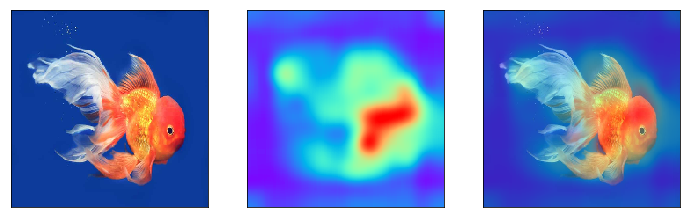

In [16]:
img = original_image
img = img.resize((224,224))
result = Image.open("results/goldfish_Cam_Heatmap.png")
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(result)
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(img)
plt.imshow(cam, alpha=0.4, cmap='rainbow')  #alpha设置透明度, cmap可以选择颜色
plt.xticks([])
plt.yticks([])
 
plt.show()

In [50]:
from PIL import Image
import numpy as np
import torch

from misc_functions import get_example_params, save_class_activation_images


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1,2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.zeros(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        #cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam /= np.max(cam)
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam


In [60]:
# Get params
target_example = 4
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
file_name_to_export += 'gradcam'
# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=29)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')

Grad cam completed


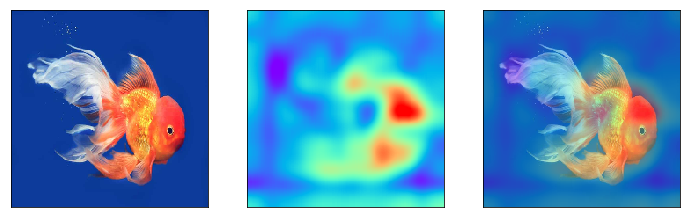

In [61]:
img = original_image
img = img.resize((224,224))
result = Image.open("results/goldfishgradcam_Cam_Heatmap.png")
plt.figure(figsize=(12,12))
plt.subplot(131)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(result)
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(img)
plt.imshow(cam, alpha=0.4, cmap='rainbow')  #alpha设置透明度, cmap可以选择颜色
plt.xticks([])
plt.yticks([])
 
plt.show()